# Path Planning with Gaussian Processes

In [1]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import tueplots
from tueplots import bundles
plt.rcParams.update(bundles.neurips2022())

# Scientific computing
import numpy as np
import probnum
import itergp
import pykeops
pykeops.set_verbose(False)

Libraries used: ProbNum, IterGP, KeOps
-> GitHub links

## Learning to Navigate

Imagine you've landed a robot on a remote planet and are now trying to explore that planet to find potential life forms. The spaceship which landed your robot is still orbiting the planet and taking measurements of the elevation to enable you to navigate on the planet.

<p style="text-align:center;">
<img src='learning_to_plan_illustration.jpg' width="800">
</p>

### Landscape Data

In [2]:
from landscapes import generate_landscape
from dataset import Dataset

# True landscape unknown to our robot
landscape_fn = generate_landscape(seed=0)

# Satellite measurements
num_train_data = 100000
train_data = Dataset(landscape_fn, num=num_train_data)
train_data.X.shape

(100000, 2)

To give you an idea, on the left is a simulated landscape, versus the actual data you obtain is on the right.

In [3]:
%matplotlib inline
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Simulated landscape
    simulated_landscape_fn = generate_landscape(seed=42)
    xs = np.linspace(0, 1.0, 100)
    ys = np.linspace(0, 1.0, 100)
    X, Y = np.meshgrid(xs, ys)
    Z = simulated_landscape_fn(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    axs[0].contourf(X, Y, Z, levels=50, cmap="terrain")

    # Simulated landscape data
    simulated_train_data = Dataset(simulated_landscape_fn, num=num_train_data)
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    axs[1].scatter(simulated_train_data.X[0:n_subset, 0], simulated_train_data.X[0:n_subset, 1], c=simulated_train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Unknown landscape")
    axs[1].set(title="Available data")
    plt.show()

### Path Planning

Now to efficiently explore the remote planet we want to move with our robot to a certain location. However, we only have limited energy resources available and need to take a path that is efficient to drive along.

In [4]:
startpoint = np.asarray([0.1, 0.1])
endpoint = np.asarray([0.9, 0.9])

You can plan two different paths in the widget below and measure their energy cost. Try to find an energy efficient path simply from the measurement data. 

*Hint:* You can add points by clicking on the corresponding path in the legend and remove points by right-clicking near the point to be removed.

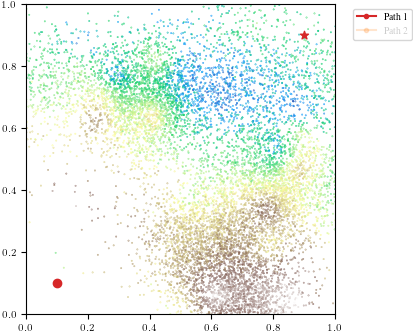

In [5]:
%matplotlib widget
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()

    # Landscape data
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    ax.scatter(train_data.X[0:n_subset, 0], train_data.X[0:n_subset, 1], c=train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Plot start and endpoints
    ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
    ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(ax, path_list, markers=[".", "."], colors=["C3", "C1"], linestyle= "-")
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})
    
    # Plot settings
    ax.set_aspect("equal")
    # ax.set_facecolor("black")
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.show()


In [6]:
# Create paths and add endpoint to each path
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)


In [7]:
from cost_functions import movement_cost

# TODO: this is actually not known! Only after driving the path.
print(f"Energy cost of path 1: {movement_cost(path1, landscape=landscape_fn): 4.4f}")
print(f"Energy cost of path 2: {movement_cost(path2, landscape=landscape_fn): 4.4f}")


Energy cost of path 1:  0.0000
Energy cost of path 2:  0.0000


## Gaussian Processes

Path planning is quite difficult simply from the datapoints. Especially, because in practice we *do not know the real energy cost* and *have only one shot* at planning a good path. Let's try to learn the surface of the remote planet from the data instead. Since we want to use energy conservatively, we need a model with uncertainty, to avoid unknown hills or valleys. We'll use a Gaussian process for this purpose.

## Scaling to Large Datasets

In [8]:
from probnum import randvars, linops
from probnum.randprocs import mean_fns
from itergp.kernels import Matern
from itergp import GaussianProcess, methods

input_shape=(2,)

# GP prior
mean_fn = mean_fns.Zero(input_shape)
kernel = Matern(input_shape, lengthscale=0.2, nu=3.5)

gp = GaussianProcess(mean_fn, kernel)

# Likelihood
sigma_sq = 0.1
noise = randvars.Normal(
    mean=np.zeros_like(train_data.y),
    cov=linops.Scaling(sigma_sq, shape=(num_train_data, num_train_data)),
)

In [9]:
# Implement Gaussian process via Cholesky decomposition


In [10]:
# Fit GP on >100000 data points

# Need kernel matrix -> 149 GiB ~= 160 GB
Khat = kernel.matrix(train_data.X) + sigma_sq * np.eye(num_train_data)

MemoryError: Unable to allocate 149. GiB for an array with shape (100000, 100000, 2) and data type float64

### Matrix-free Kernel Matrices

Kernel operations on the GPU without memory overflow: [KeOps](https://www.kernel-operations.io/keops/index.html).

<p style="text-align:center;">
<img src='keops.png' width="800">
</p>

In [11]:
# Matrix-free representation of kernel matrix as "linear operator"
K = kernel.linop(train_data.X)

# Large-scale matrix-vector product still possible
(K @ np.ones(num_train_data)).shape

(100000,)

## Computation-Aware Inference

In [12]:
# Accurate images on satellite around Mars, but communication with earth is slow and hardware is limited on satellite / robot. Need fast inference with little computation time.

# Iterative gp posterior
gp_post = gp.condition_on_data(
    train_data.X, train_data.y, noise, approx_method=methods.Cholesky(maxrank=10)
)


In [13]:
import cProfile

# Profile to understand which calls are expensive
# totime:  total time spent in the given function (excluding time in calls to sub-functions)
# cumtime: cumulative time spent in this and all subfunctions
cProfile.run(
    "gp.condition_on_data(train_data.X, train_data.y, noise, approx_method=methods.CG(maxiter=3))",
    sort="tottime",
)


         11212 function calls (11186 primitive calls) in 10.238 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6   10.205    1.701   10.205    1.701 LoadKeOps_nvrtc.py:41(call_keops)
  197/187    0.005    0.000    0.007    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        3    0.001    0.000    0.009    0.003 projected_residual.py:103(updated_linsys_belief)
       12    0.001    0.000    0.001    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        4    0.001    0.000    0.002    0.000 _orthogonalize.py:70(gram_schmidt_modified)
        6    0.001    0.000    0.003    0.000 lazy_tensor.py:271(fixvariables)
       11    0.001    0.000   10.222    0.929 {built-in method _functools.reduce}
      132    0.001    0.000    0.002    0.000 lazy_tensor.py:63(__init__)
       65    0.001    0.000    0.001    0.000 {method 'astype' of 'numpy.ndarray' objects}
        6    0.001    0.000

In [42]:
# GP prediction on a million datapoints
xs = np.linspace(0, 1.0, 1000)
ys = np.linspace(0, 1.0, 1000)
X, Y = np.meshgrid(xs, ys)
X_pred = np.vstack([X.ravel(), Y.ravel()]).T
y_pred = gp_post.mean(X_pred)
uncertainty = gp_post.std(X_pred)

(1000000, 2)


In [43]:
X_pred.shape

(1000000, 2)

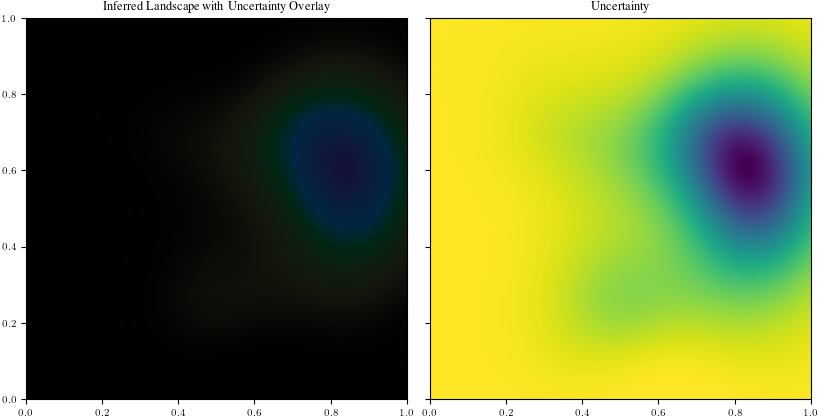

In [41]:
%matplotlib widget
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.5)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # Evaluate landscape function for plotting
    # axs[0].contourf(X, Y, y_pred.reshape(X.shape), cmap="terrain", levels=50)
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        black_background = np.full((*X.shape, 3), 0, dtype=np.uint8)
        axs[0].imshow(black_background)
        uncertainty_overlay = 1.0 - uncertainty.reshape(X.shape)/np.max(uncertainty)

    axs[0].imshow(
        y_pred.reshape(X.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
    )

    # Uncertainty
    # axs[1].contourf(
    #     X, Y, gp_post.std(X_pred).reshape(X.shape), cmap="viridis", levels=50
    # )
    axs[1].imshow(
        uncertainty.reshape(X.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
    )

    # Plot settings
    axs[0].set_title("Inferred Landscape with Uncertainty Overlay" if use_uncertainty_overlay else "Inferred Landscape")
    axs[1].set_title("Uncertainty")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)
    plt.show()


### Design Your Own Approximation Method

In [35]:
from typing import Optional
from probnum.backend.random import RNGState

import probnum
from probnum import backend
from probnum.linalg.solvers import ProbabilisticLinearSolver, information_ops, policies

from itergp.methods import belief_updates, stopping_criteria


class MyPolicy(policies.LinearSolverPolicy):

    def __init__(self) -> None:
        super().__init__()

    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState],
    ) -> backend.Array:
        """Return an action for a given solver state.

        Parameters
        ----------
        solver_state
            Current state of the linear solver.
        rng
            Random number generator state.

        Returns
        -------
        action
            Next action to take. Must have shape=(n,).
        """
        rng = np.random.default_rng(rng)

        return rng.standard_normal(size=(solver_state.problem.A.shape[1],))





In [ ]:
class MySolver(ProbabilisticLinearSolver):
    r"""
    Parameters
    ----------
    atol
        Absolute tolerance.
    rtol
        Relative tolerance.
    maxiter
        Maximum number of iterations.
    """

    def __init__(
        self,
        atol: float = 1e-6,
        rtol: float = 1e-6,
        maxiter: int = None,
    ):
        super().__init__(
            policy=MyPolicy(),
            information_op=information_ops.ProjectedResidualInformationOp(),
            belief_update=belief_updates.ProjectedResidualBeliefUpdate(),
            stopping_criterion=stopping_criteria.MaxIterationsStoppingCriterion(
                maxiter=maxiter,
            )
            | probnum.linalg.solvers.stopping_criteria.ResidualNormStoppingCriterion(
                atol=atol, rtol=rtol
            ),
        )

In [38]:
gp_post = gp.condition_on_data(
    train_data.X, train_data.y, noise, approx_method=MySolver(maxiter=1)
)


In [ ]:
# Use clicker to let people choose observation points (and their weighing through an array later on)?



In [ ]:
# TODO: ensure PLS doesnt save all residuals in between to scale to 100k datapoints more easily?